## Imports

In [1]:
import pandas_profiling
import spacy
import textacy
import pandas as pd
import os
import ruamel.yaml as yaml
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
pd.options.display.max_columns= 150



#nlp = spacy.load('en')
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Change to root directory

In [2]:
NO_CONFIG_ERR_MSG = """No config file found. Root directory is determined by presence of "config.yaml" file."""        

original_wd = os.getcwd()

# Number of times to move back in directory
num_retries = 10
for x in range(0, num_retries):
    # try to load config file    
    try:
        with open("config.yaml", 'r') as stream:
            cfg = yaml.safe_load(stream)
    # If not found move back one directory level
    except Exception:
        os.chdir('../')
        # If reached the max number of directory levels change to original wd and print error msg
        if x+1 == num_retries:
            os.chdir(original_wd)
            print(NO_CONFIG_ERR_MSG)

## Import local code

In [3]:
from src.convenience_functions.textacy_convenience_functions import load_textacy_corpus
from src.convenience_functions.textacy_convenience_functions import entity_statements
from src.convenience_functions.textacy_convenience_functions import list_of_entity_statements
from src.convenience_functions.textacy_convenience_functions import dask_df_apply
from src.textblob_entity_sentiment import textblob_entity_sentiment

## Load Data

Using movie reviews from lablled IMDB sentiment reviews from [UCI Machine Learning lab](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

In [4]:
text_df = text_reviews = pd.read_table('notebooks/imdb_labelled.txt', header = None)
# Assigining column names and labeled sentiments
text_df.columns = columns=['text', 'sentiment_label']
text_df['sentiment_label'] = text_df['sentiment_label'].map({0:'negative', 1:'positive'})
text_df.head()

,text,sentiment_label
0,"A very, very, very slow-moving, aimless movie ...",negative
1,Not sure who was more lost - the flat characte...,negative
2,Attempting artiness with black & white and cle...,negative
3,Very little music or anything to speak of.,negative
4,The best scene in the movie was when Gerardo i...,positive


## Dask Multiprocessing of applied textacy docs

Using dask to multiprocess the loading of textacy docs for each text

1. Use dask to create partitioned dataframe

2. To each partition map an apply that creates textacy docs from the Policy_Text column

3. Concatenate back to original df

In [5]:
%%time
textacy_df = dask_df_apply(text_df, 'text', inplace=True)

Wall time: 37.9 s


In [6]:
textacy_df.textacy_doc.values[0]

Doc(21 tokens; "A very, very, very slow-moving, aimless movie a...")

## Extracting Entity Text, Counts and Sentiments

In [7]:
entities_for_sentiment =['characters', 'plot', 'hero', 'villain']

#### For each entity selected, return the count of entity occurence as well as mean, min and max of sentiments of sentences that contain said entity

In [8]:
%%time 
sentiments = [textblob_entity_sentiment(df=textacy_df, 
                                        textacy_col='textacy_doc', 
                                        entity=entity, 
                                        inplace=False,
                                       keep_stats=['count', 'mean', 'min', 'max']) 
              for entity
              in entities_for_sentiment]
# Concat to single df
sentiments = pd.concat(sentiments, axis=1)

Wall time: 7.45 s


#### As with most text features, these will be sparse

In [9]:
texts_with_sentiment_info = pd.concat([textacy_df, sentiments], axis=1)

In [10]:
texts_with_sentiment_info.head()

,text,sentiment_label,textacy_doc,characters_polarity_count,characters_polarity_mean,characters_polarity_min,characters_polarity_max,plot_polarity_count,plot_polarity_mean,plot_polarity_min,plot_polarity_max,hero_polarity_count,hero_polarity_mean,hero_polarity_min,hero_polarity_max,villain_polarity_count,villain_polarity_mean,villain_polarity_min,villain_polarity_max
0,"A very, very, very slow-moving, aimless movie ...",negative,"(A, very, ,, very, ,, very, slow, -, moving, ,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Not sure who was more lost - the flat characte...,negative,"(Not, sure, who, was, more, lost, -, the, flat...",1.0,0.014583,0.014583,0.014583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Attempting artiness with black & white and cle...,negative,"(Attempting, artiness, with, black, &, white, ...",NaN,NaN,NaN,NaN,1.0,-0.122917,-0.122917,-0.122917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Very little music or anything to speak of.,negative,"(Very, little, music, or, anything, to, speak,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,The best scene in the movie was when Gerardo i...,positive,"(The, best, scene, in, the, movie, was, when, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Slicing Sentiments by Label

In [11]:
groupby_label = (
 # Group by sentiment label
 texts_with_sentiment_info.groupby(by=['sentiment_label'])
 # Find mean
 .mean()
 # Filter down to character/plot sentiment entity average
 .filter(regex='characters.*mean$|plot.*mean$')
 .reset_index()
 # melt down to tidy data format
 .pipe(pd.melt, id_vars=['sentiment_label'],
                         value_vars=['characters_polarity_mean', 'plot_polarity_mean'],
                         var_name='entity',
                         value_name='avg_sentiment')
 # Split entity string down to entity searched for
 .assign(entity= lambda x: x['entity'].apply(lambda x: x.split('_')[0]) )
)

## Plot Sentiment

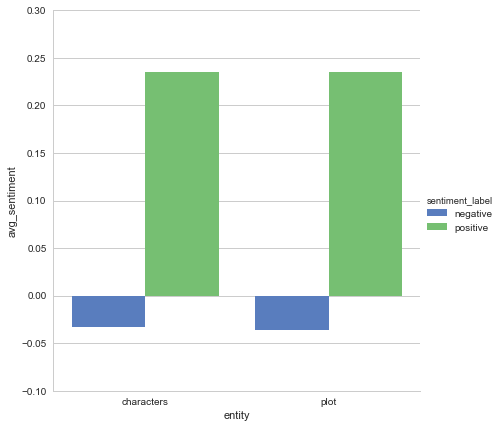

In [12]:
# Draw a nested barplot to show survival for class and sex
g = sns.factorplot(x="entity", y="avg_sentiment", hue="sentiment_label", data=groupby_label,
                   size=6, kind="bar", palette="muted").set(ylim=(-.1, .3))
g